#### Goal : 
create a test / train split without having a subject's ID appear in both files

data_split/
    train/
        Control/
        Very Mild Dementia/
        Mild Dementia/
        Moderate Dementia/
    test/
        Control/
        Very Mild Dementia/
        Mild Dementia/
        Moderate Dementia/

In [15]:
import os 
import re
import pandas as pd 
import numpy as np
import shutil
import PIL as Image
import random 

In [16]:
#set seed for "control" of randomness for splitting data // reproducibility
random.seed(2024)

#set path to data
data_dir = "../Data"

#regex for patient ID and scan type/number
patient_id_pattern = re.compile(r"OAS1_(\d+)_")
scan_pattern = re.compile(r"mpr-(\d+)_")

#classification / labels:
classification =["Control", 
                "Very Mild Dementia", 
                "Mild Dementia", 
                "Moderate Dementia"]

#init empty lists for data
labels , patient_ids, scan_ids, filenames, file_paths = [], [], [], [], []

In [17]:
# part 1: iterate over all files in the data set to extract metadata 
for category in classification:
    path = os.path.join(data_dir, category)
    
    # iterate over all files in each category directory
    for MRI_filename in os.listdir(path):
        if MRI_filename.endswith(".jpg"):
            # extract patient ID
            match = patient_id_pattern.search(MRI_filename)
            if match:
                labels.append(category)
                patient_id = match.group(1)
                patient_ids.append(patient_id)
                scan_ids.append(scan_pattern.search(MRI_filename).group(1))
                filenames.append(MRI_filename)
                file_paths.append(os.path.join(path, MRI_filename))
            else:
                print(f"Error extracting patient ID from {MRI_filename}") # just in case... - no issues yet
    print("Completed category: ", category) 
    

Completed category:  Control
Completed category:  Very Mild Dementia
Completed category:  Mild Dementia
Completed category:  Moderate Dementia


In [18]:
MRI_df = pd.DataFrame({
    'Patient_ID': patient_ids,
    'Label': labels,
    'Scan_ID': scan_ids,
    'Filename': filenames,
    'File_Path': file_paths
})

In [19]:
MRI_df.head()

,Patient_ID,Label,Scan_ID,Filename,File_Path
0,0349,Control,4,OAS1_0349_MR1_mpr-4_142.jpg,../Data/Control/OAS1_0349_MR1_mpr-4_142.jpg
1,0317,Control,1,OAS1_0317_MR1_mpr-1_141.jpg,../Data/Control/OAS1_0317_MR1_mpr-1_141.jpg
2,0234,Control,4,OAS1_0234_MR1_mpr-4_136.jpg,../Data/Control/OAS1_0234_MR1_mpr-4_136.jpg
3,0182,Control,1,OAS1_0182_MR1_mpr-1_139.jpg,../Data/Control/OAS1_0182_MR1_mpr-1_139.jpg
4,0132,Control,2,OAS1_0132_MR1_mpr-2_117.jpg,../Data/Control/OAS1_0132_MR1_mpr-2_117.jpg


### Part2 : splitting the data "cleanly" into a train/test split. 

I would have added in a validation split, but there are only 2 subjects in the moderate category of dementia and I want the model to try and be exposed to as many variations as possible without causing validation errors.

##### Step 2: Split into train and test sets by patient.
##### For each label, we will:
##### - Extract the unique patient IDs
##### - Shuffle them
##### - Split 80% train, 20% test


In [20]:
MRI_df.groupby('Label')['Patient_ID'].nunique() ## total is 347 patients

Label
Control               266
Mild Dementia          21
Moderate Dementia       2
Very Mild Dementia     58
Name: Patient_ID, dtype: int64

In [21]:
# splitting the Control group in half before splitting all of the subjects into train and test set

In [22]:
control_subjects = MRI_df[MRI_df['Label'] == 'Control']['Patient_ID'].unique()

# Randomly select 1/3  to keep
subjects_to_keep = random.sample(list(control_subjects), len(control_subjects) // 3)

# Filter the DataFrame to only include the selected subjects
MRI_df_reduced = MRI_df[
    (MRI_df['Label'] != 'Control') | (MRI_df['Patient_ID'].isin(subjects_to_keep))
    ]


In [23]:
MRI_df_reduced.groupby('Label')['Patient_ID'].nunique()

Label
Control               88
Mild Dementia         21
Moderate Dementia      2
Very Mild Dementia    58
Name: Patient_ID, dtype: int64

In [24]:
train_ratio = 0.8   
train_patients, test_patients = {} , {}

In [25]:
for category in classification:
    ## unique patients IDs in each category
    unique_patients = MRI_df_reduced.loc[MRI_df['Label'] == category]['Patient_ID'].unique().tolist()
    random.shuffle(unique_patients) # shuffle the ids by category (for randomness)
    
    ## split index
    split_index = int(train_ratio * len(unique_patients))
    
    ## assign subjects to train/test files
    train_patients[category] = unique_patients[:split_index]
    test_patients[category] = unique_patients[split_index:]


In [26]:
# check the patients in the moderate dementia groups are properly split 
# -- they should not come up in both train and test (1 patient in both)

print(f"TRAIN: \n {train_patients['Moderate Dementia']} \nTEST: \n {test_patients['Moderate Dementia']}")


TRAIN: 
 ['0351'] 
TEST: 
 ['0308']


### Assign the subjects and their images to their respective files 

In [27]:
output_path= "../Organized_Data"
train_dir = os.path.join(output_path, "train")
test_dir = os.path.join(output_path, "test")

for directory in [output_path, train_dir, test_dir]:
    if not os.path.exists(directory):
        os.makedirs(directory, exist_ok=True)
        
for category in classification:
    os.makedirs(os.path.join(train_dir, category), exist_ok=True)
    os.makedirs(os.path.join(test_dir, category), exist_ok=True)
    
    # Copy/move TRAIN subjects files/images
    for patient_id in train_patients[category]:
        # select all rows with TRAIN patient_id and category
        subset = MRI_df_reduced[(MRI_df_reduced['Patient_ID'] == patient_id) & (MRI_df_reduced['Label'] == category)]
        for row in subset.itertuples():
            shutil.copy(row.File_Path, os.path.join(train_dir, category, row.Filename))

    # Copy/move TEST subjects files/images
    for patient_id in test_patients[category]:
        # select all rows with TEST patient_id and category
        subset = MRI_df_reduced[(MRI_df_reduced['Patient_ID'] == patient_id) & (MRI_df_reduced['Label'] == category)]
        for row in subset.itertuples():
            shutil.copy(row.File_Path, os.path.join(test_dir, category, row.Filename))

print("Data has been split into train and test sets successfully!")

Data has been split into train and test sets successfully!


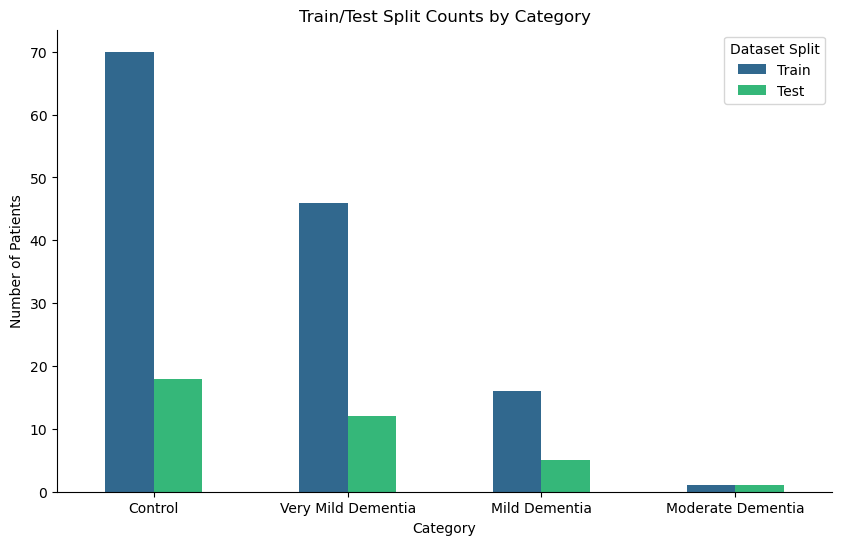

In [29]:

import seaborn as sns
import matplotlib.pyplot as plt

# number of patients in each category for train and test sets
train_counts = {category: len(patients) for category, patients in train_patients.items()}
test_counts = {category: len(patients) for category, patients in test_patients.items()}

# dataFrame for plotting
split_counts_df = pd.DataFrame({'Train': train_counts, 'Test': test_counts})

# color palette
category_colors = sns.color_palette("viridis", n_colors=2)

# plotting
split_counts_df.plot(kind='bar', figsize=(10, 6), color=category_colors)
plt.title('Train/Test Split Counts by Category')
plt.xlabel('Category')
plt.ylabel('Number of Patients')
plt.legend(title='Dataset Split')
xticks = plt.xticks(rotation=0)
sns.despine()
plt.show()

In [15]:
os.makedirs("../Metadata", exist_ok=True)

In [16]:
MRI_df.to_csv("../Metadata/MRI_metadata.csv", index=False)
print("Metadata has been saved successfully!")
sorted_MRI_df=MRI_df.sort_values(by='Patient_ID', inplace=False)
sorted_MRI_df.to_csv("../Metadata/Sorted_MRI_metadata.csv", index=False)

MRI_df_reduced.to_csv("../Metadata/Reduced_MRI_metadata.csv", index=False)
sorted_MRI_df_reduced=MRI_df_reduced.sort_values(by='Patient_ID', inplace=False)
sorted_MRI_df_reduced.to_csv("../Metadata/Sorted_Reduced_MRI_metadata.csv", index=False)

print("Sorted Metadata has been saved successfully!")

Metadata has been saved successfully!
Sorted Metadata has been saved successfully!


In [17]:
print( MRI_df.size, MRI_df_reduced.size) 

432185 210145
